<a href="https://colab.research.google.com/github/nitrus96/Deep-RL/blob/master/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.15.0
Average score over 10 episodes at episode 10 : 16.1
Average score over 10 episodes at episode 20 : 12.0
Average score over 10 episodes at episode 30 : 33.5
Average score over 10 episodes at episode 40 : 135.0
Average score over 10 episodes at episode 50 : 223.1
Average score over 10 episodes at episode 60 : 243.4
Average score over 10 episodes at episode 70 : 245.5
Average score over 10 episodes at episode 80 : 248.3
Average score over 10 episodes at episode 90 : 207.3
Average score over 10 episodes at episode 100 : 235.0
Average score over 10 episodes at episode 110 : 214.9
Average score over 10 episodes at episode 120 : 238.9
Average score over 10 episodes at episode 130 : 224.2
Average score over 10 episodes at episode 140 : 214.7
Average score over 10 episodes at episode 150 : 197.3
Average score over 10 episodes at episode 160 : 198.0
Average score over 10 episodes at episode 170 : 231.5
Average score over 10 episodes at episode 180 : 167.8
Average score over 10 episodes at

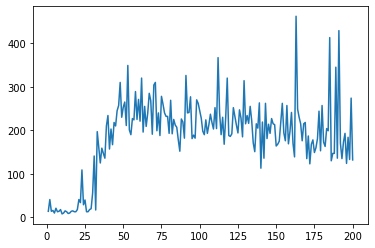

In [6]:
import random
from itertools import count
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym
import tensorflow
from tensorflow.keras import models, layers
from tensorflow.keras.initializers import glorot_normal
from collections import deque
from tensorflow.keras.optimizers import Nadam

### Environment ##
ENV = gym.make('CartPole-v1')
OBSERVATION_SPACE = ENV.observation_space.shape[0]
ACTION_SPACE = ENV.action_space.n

### Hyperparameters ###
LR = 0.001
BATCH_SIZE = 32
GAMMA = 0.9

EPISODES = 200
MEM_SIZE = 100000
EXPLORATION_RATE = 0.95
EXPLORATION_DECAY = 0.995

print(tensorflow.__version__)

class DQNet:

  def __init__(self):
    self.model = models.Sequential([
    layers.Dense(64, input_dim = OBSERVATION_SPACE, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(ACTION_SPACE, activation='linear')])
    self.model.compile(optimizer=Nadam(learning_rate=LR),
              loss='mse')


class Agent:

  def __init__(self):
    # Replay memory
    self.memory = deque(maxlen=MEM_SIZE)
    # Initalize action policy
    self.action_policy = DQNet()
    self.epsilon = EXPLORATION_RATE

  def sample_action(self, observation):
    # Exploration rate decays with each action taken
    self.epsilon *= EXPLORATION_DECAY
    # Choose random action or act greedily according to the current policy
    if random.random() < self.epsilon:
      return np.random.choice(2, 1)[0]
    else:
      return np.argmax(self.action_policy.model.predict(observation))

  # Add observation to replay memory
  def add_to_memory(self, ts):
    self.memory.append(ts)  
    
  def replay_from_memory(self):
    # Assert we have enough observation instances in our memory
    if len(self.memory) < BATCH_SIZE:
      return
    else:
      x_batch, y_batch = [], []
      batch = random.sample(self.memory, BATCH_SIZE)
      for s, a, r, next_s, done in batch:
        # If terminal, target is equal to the reward
        if done:
          y = r
        else:
          next_a = self.action_policy.model.predict(next_s)
          y = r + GAMMA * np.max(next_a)
        q_val = self.action_policy.model.predict(s)
        q_val[0][a] = y
        # Samples are to be processed as a batch
        x_batch.append(s[0])
        y_batch.append(q_val[0])
      # Perform gradient update
      self.action_policy.model.fit(np.array(x_batch), np.array(y_batch),
                                   batch_size=BATCH_SIZE, verbose = 0)
      
class Env:

  def __init__(self, env):
    self.env = env
    self.agent = Agent()
    self.episode = 1
    self.scores = 0
    self.chart_performance = []

    # Start playing
    for episode in range(EPISODES):
      self.play_episode()
    
    # Save model
    self.agent.action_policy.model.save_weights('dqn_weights.h5')

    # Plot scores for each episode when done training
    plt.plot(np.arange(1, EPISODES+1), self.chart_performance)
    plt.show()

  def play_episode(self):
    observation = self.env.reset().reshape(1,OBSERVATION_SPACE)
    counter = 0
    while True:
      action = self.agent.sample_action(observation)
      next_observation, reward, done, info = self.env.step(action)
      next_observation = next_observation.reshape(1,OBSERVATION_SPACE)
      # Store transition tuple in replay memory
      self.agent.add_to_memory((observation, action, reward, next_observation, done))
      counter += 1
      # Update statistics at the end of each episode
      if done:
        self.episode += 1
        self.scores += counter
        self.chart_performance.append(counter)
        if self.episode % 10 == 0:
          print("Average score over 10 episodes at episode {} : {}".format(self.episode, self.scores/10))
          self.scores = 0
        break
      observation = next_observation
      # Experience replay
      self.agent.replay_from_memory()

if __name__ == '__main__':
  env = Env(ENV)